This will be my notebook for conducting speedy Bayesian mixed-effects logistic regression on behavior. 


Notes
___


- Bambi needs up-to-date xarray (for 'unify_chunks' method), while the data I pickled used xarray 0.13.0 


- Bambi can't multi-process sampling across multiple chains if you import joblib, so need to make sure to only load in csv data. 

In [1]:
import arviz as az
import bambi as bmb
import argparse
from os.path import join
import pandas as pd
from pandas.api.types import CategoricalDtype
import seaborn as sns 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from Bayesian_model_utils import run_model, plot_res, print_latex_table, plot_predictions

## How do arousal and valence predict recall performance?

In [2]:
# Model 1: Effect of arousal and continuous, linear valence on recall 

# Old dataset of pts with Hipp or Amy electrodes 
# behav_df = pd.read_csv('/home1/salman.qasim/Salman_Project/FR_Emotion/events_all.csv', low_memory=False)

# 5/4/2022: Try this with 365 free recall patients (200 more than before) 
behav_df = pd.read_csv('/home1/salman.qasim/Salman_Project/FR_Emotion/events_all_patients_revision.csv', memory_map=True)

behav_df = behav_df.drop(columns=['Unnamed: 0'])

# Get only encoding events
behav_df = behav_df[behav_df.type=='WORD']

# Center valence using mean of whole database to capture relative polarity
behav_df.valence = behav_df.valence - 0.5

behav_df = behav_df[['recalled', 'arousal', 'valence', 'subject']]

y = 'recalled'
X = ['arousal', 'valence'] 
Intx = ['arousal:valence']
rand_effect = ['subject']

# Drop nan data
behav_df = behav_df.dropna(subset=X)

label = (f"{y}" + "_{}"*len(X)).format(*X) + '_allFRpts'

# Set some terms 
rand_term = [f'(1|{x})' for x in rand_effect]
formula = f'{y} ~ 1+'+'+'.join(rand_term)+'+'+'+'.join(X)+'+'+'+'.join(Intx)
model_fam = 'bernoulli'
priors=None
categorical=None

# construct the model 
model = bmb.Model(formula=formula, 
              data=behav_df[rand_effect + [y] + X],
             family=model_fam,
             priors=priors,
             categorical=categorical)

model.build()

/tmp/2833564.1.jupyter.q/ipykernel_64249/589411149.py:7: DtypeWarning: Columns (3,6,94) have mixed types. Specify dtype option on import or set low_memory=False.
  behav_df = pd.read_csv('/home1/salman.qasim/Salman_Project/FR_Emotion/events_all_patients_revision.csv', memory_map=True)


array([[<AxesSubplot:title={'center':'Intercept'}>,
        <AxesSubplot:title={'center':'arousal'}>,
        <AxesSubplot:title={'center':'valence'}>],
       [<AxesSubplot:title={'center':'arousal:valence'}>,
        <AxesSubplot:title={'center':'1|subject_sigma'}>, <AxesSubplot:>]],
      dtype=object)

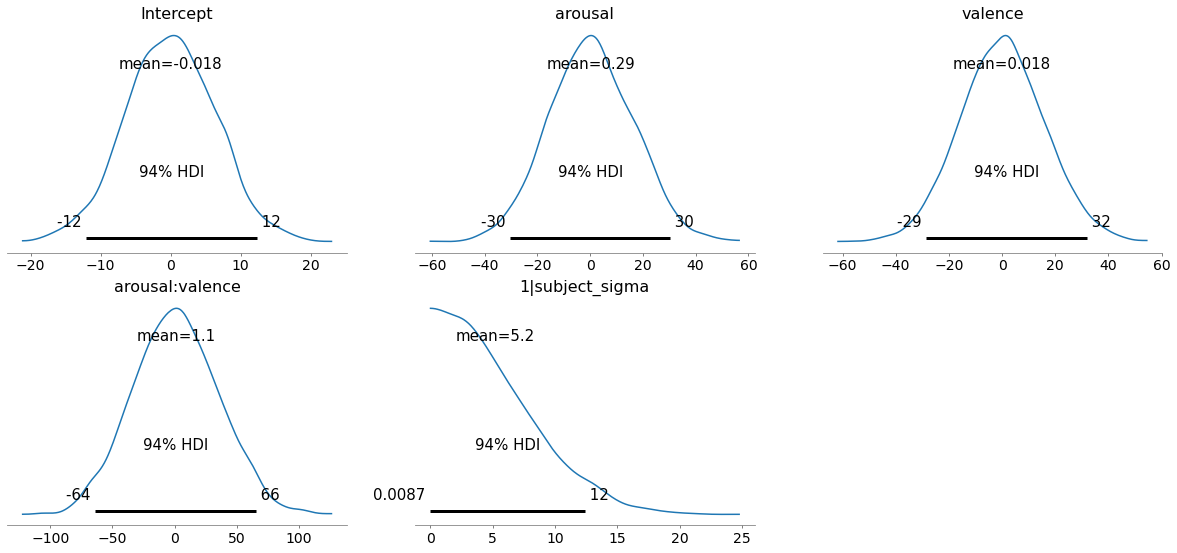

In [3]:
# Check the priors - are these sensible?
model.plot_priors()

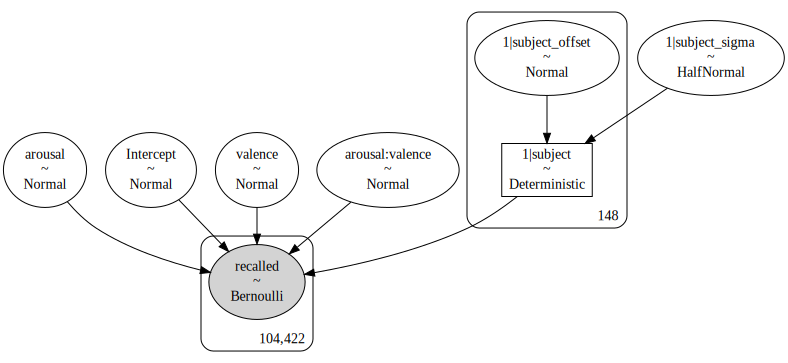

In [4]:
model.graph()

Our model formulation looks sensible. Let's do it.

In [3]:
# Model 1: Effect of arousal and continuous, linear valence on recall 

# Old dataset of pts with Hipp or Amy electrodes 
# behav_df = pd.read_csv('/home1/salman.qasim/Salman_Project/FR_Emotion/events_all.csv', low_memory=False)

# 5/4/2022: Try this with 365 free recall patients (200 more than before) 
behav_df = pd.read_csv('/home1/salman.qasim/Salman_Project/FR_Emotion/events_all_patients_revision.csv', memory_map=True)

behav_df = behav_df.drop(columns=['Unnamed: 0'])

# Get only encoding events
behav_df = behav_df[behav_df.type=='WORD']

# Center valence using mean of whole database to capture relative polarity
behav_df.valence = behav_df.valence - 0.5

behav_df = behav_df[['recalled', 'arousal', 'valence', 'subject']]

y = 'recalled'
X = ['arousal', 'valence'] 
Intx = ['arousal:valence']
rand_effect = ['subject']

# Drop nan data
behav_df = behav_df.dropna(subset=X)

label = (f"{y}" + "_{}"*len(X)).format(*X) + '_allFRpts'

# Run the model 
run_model(behav_df, y, X, Intx, rand_effect, 
          chains=4, cores=4, tune=1000, draws=1000, 
          label = label, rand_slopes=False)

/tmp/2818473.1.jupyter.q/ipykernel_17411/1045270821.py:7: DtypeWarning: Columns (3,6,94) have mixed types. Specify dtype option on import or set low_memory=False.
  behav_df = pd.read_csv('/home1/salman.qasim/Salman_Project/FR_Emotion/events_all_patients_revision.csv', memory_map=True)
Modeling the probability that recalled==1
Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Convergence achieved at 24300
Interrupted at 24,299 [48%]: Average Loss = 67,729
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [1|subject_offset, 1|subject_sigma, arousal:valence, valence, arousal, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2172 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.
/home1/salman.qasim/Salman_Python_Scripts/SQ_Projects/Bayesian_model_utils.py:142: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(results_df.reset_index().to_latex(index=False,


\begin{tabular}{|c|c|c|c|}
\toprule
          index &   mean &    sd &  hdi\_2.5\% &  hdi\_97.5\% \\ \hline
\midrule
        arousal &  0.368 & 0.047 &     0.280 &      0.459 \\ \hline
arousal:valence & -0.174 & 0.242 &    -0.643 &      0.306 \\ \hline
        valence &  0.000 & 0.114 &    -0.224 &      0.220 \\ \hline
arousal:valence & -0.174 & 0.242 &    -0.643 &      0.306 \\ \hline
\bottomrule
\end{tabular}



In [4]:
# Model 1: Effect of arousal and continuous, linear valence on recall 

# Old dataset of pts with Hipp or Amy electrodes 
# behav_df = pd.read_csv('/home1/salman.qasim/Salman_Project/FR_Emotion/events_all.csv', low_memory=False)

# 5/4/2022: Try this with 365 free recall patients (200 more than before) 
behav_df = pd.read_csv('/home1/salman.qasim/Salman_Project/FR_Emotion/events_all_patients_revision.csv', memory_map=True)

behav_df = behav_df.drop(columns=['Unnamed: 0'])

# Get only encoding events
behav_df = behav_df[behav_df.type=='WORD']

# Center valence using mean of whole database to capture relative polarity
behav_df['valence_squared'] = (behav_df.valence - 0.5)**2

behav_df = behav_df[['recalled', 'arousal', 'valence_squared', 'subject']]

y = 'recalled'
X = ['arousal', 'valence_squared'] 
Intx = ['arousal:valence_squared']
rand_effect = ['subject']

# Drop nan data
behav_df = behav_df.dropna(subset=X)

label = (f"{y}" + "_{}"*len(X)).format(*X) + '_allFRpts'

# Run the model 
run_model(behav_df, y, X, Intx, rand_effect, 
          chains=4, cores=4, tune=1000, draws=1000, 
          label = label, rand_slopes=False)

/tmp/2818473.1.jupyter.q/ipykernel_17411/35880295.py:7: DtypeWarning: Columns (3,6,94) have mixed types. Specify dtype option on import or set low_memory=False.
  behav_df = pd.read_csv('/home1/salman.qasim/Salman_Project/FR_Emotion/events_all_patients_revision.csv', memory_map=True)
Modeling the probability that recalled==1
Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Convergence achieved at 23500
Interrupted at 23,499 [46%]: Average Loss = 68,474
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [1|subject_offset, 1|subject_sigma, arousal:valence_squared, valence_squared, arousal, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2013 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/home1/salman.qasim/Salman_Python_Scripts/SQ_Projects/Bayesian_model_utils.py:142: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(results_df.reset_index().to_latex(index=False,


\begin{tabular}{|c|c|c|c|}
\toprule
                  index &   mean &    sd &  hdi\_2.5\% &  hdi\_97.5\% \\ \hline
\midrule
                arousal &  0.274 & 0.061 &     0.150 &      0.393 \\ \hline
arousal:valence\_squared &  2.176 & 1.032 &     0.203 &      4.259 \\ \hline
        valence\_squared & -0.514 & 0.470 &    -1.466 &      0.356 \\ \hline
arousal:valence\_squared &  2.176 & 1.032 &     0.203 &      4.259 \\ \hline
\bottomrule
\end{tabular}



In [ ]:
# Model 1: Effect of arousal and continuous, linear valence on recall 

# Old dataset of pts with Hipp or Amy electrodes 
# behav_df = pd.read_csv('/home1/salman.qasim/Salman_Project/FR_Emotion/events_all.csv', low_memory=False)

# 5/4/2022: Try this with 365 free recall patients (200 more than before) 
behav_df = pd.read_csv('/home1/salman.qasim/Salman_Project/FR_Emotion/events_all_patients_revision.csv', memory_map=True)

behav_df = behav_df.drop(columns=['Unnamed: 0'])

# Get only encoding events
behav_df = behav_df[behav_df.type=='WORD']

behav_df = behav_df[['recalled', 'arousal', 'CV', 'subject']]

y = 'recalled'
X = ['arousal', 'CV'] 
Intx = ['arousal:CV']
rand_effect = ['subject']
categorical =['CV'] 
# Drop nan data
behav_df = behav_df.dropna(subset=X)

label = (f"{y}" + "_{}"*len(X)).format(*X) + '_allFRpts'

# Run the model 
run_model(behav_df, y, X, Intx, rand_effect, categorical=categorical, 
          chains=4, cores=4, tune=1000, draws=1000, 
          label = label, rand_slopes=False)

/tmp/2818473.1.jupyter.q/ipykernel_17411/1193381368.py:7: DtypeWarning: Columns (3,6,94) have mixed types. Specify dtype option on import or set low_memory=False.
  behav_df = pd.read_csv('/home1/salman.qasim/Salman_Project/FR_Emotion/events_all_patients_revision.csv', memory_map=True)
Modeling the probability that recalled==1
Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Convergence achieved at 26400
Interrupted at 26,399 [52%]: Average Loss = 70,023
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [1|subject_offset, 1|subject_sigma, arousal:CV, CV, arousal, Intercept]


Let's now do model comparison using leave-one-out cross-validation and determine which formulation of valence is best for prediction. 

Source:
https://arviz-devs.github.io/arviz/api/generated/arviz.compare.html

https://arviz-devs.github.io/arviz/api/generated/arviz.plot_compare.html

https://bambinos.github.io/bambi/main/notebooks/model_comparison.html?highlight=waic


In [ ]:
# Model comparison: use PSI-LOO

# Load each model
save_dir = '/home1/salman.qasim/Salman_Project/FR_Emotion/BayesModels'
linear_valence = az.from_netcdf(f'{save_dir}/recalled_arousal_valence_allFRpts_model')
valence_squared = az.from_netcdf(f'{save_dir}/recalled_arousal_valence_squared_allFRpts_model')
binned_valence = az.from_netcdf(f'{save_dir}/recalled_arousal_CV_allFRpts_model')

models = {"linear_valence": linear_valence, 
          "valence_squared": valence_squared,
         "binned_valence": binned_valence}

df_compare = az.compare(models, ic='loo')
plot_df = df_compare.reset_index().rename(columns={'index':'model'})[['model', 'loo']]

c_string = '|c'*plot_df.shape[1] + '|'
print(plot_df.to_latex(index=False, 
                                        column_format=c_string).replace("\\\n", "\\ \hline\n"))  
az.plot_compare(df_compare, insample_dev=True)
plt.savefig(f'{save_dir}/behav_valence_comparison.pdf')

In [ ]:
az.plot_compare(df_compare, insample_dev=True)
plt.savefig(f'{save_dir}/arousal_valence_comparison.pdf')

Based on this comparison, EVERY MODEL (other than depression? We can come back to that...) should use linear valence, as it's higher log-score (lower deviance) indicates a model with better predictive accuracy.

In [10]:
# Model 3: Effect of arousal and continuous, linear valence on recall using ANEW ratings

# Old dataset of pts with Hipp or Amy electrodes 
# behav_df = pd.read_csv('/home1/salman.qasim/Salman_Project/FR_Emotion/events_all.csv', low_memory=False)

# 5/4/2022: Try this with 365 free recall patients (200 more than before) 
behav_df = pd.read_csv('/home1/salman.qasim/Salman_Project/FR_Emotion/events_all_patients.csv', memory_map=True)

behav_df = behav_df.drop(columns=['Unnamed: 0'])

# Get only encoding events
behav_df = behav_df[behav_df.type=='WORD']

# Center valence using mean of whole database to capture relative polarity
BR_emot_rankings = pd.read_csv("/home1/salman.qasim/Salman_Project/FR_Emotion/BRM-emot-submit.csv")
BR_emot_rankings.drop(columns=['Unnamed: 0'], inplace=True)
mean_zero = ((BR_emot_rankings['V.Mean.Sum'] - BR_emot_rankings['V.Mean.Sum'].min())/BR_emot_rankings['V.Mean.Sum'].max()).mean()
behav_df['V.Mean.Sum'] = behav_df['V.Mean.Sum'] - mean_zero
behav_df = behav_df[['recalled', 'A.Mean.Sum', 'V.Mean.Sum', 'subj']]

y = 'recalled'
X = ['A.Mean.Sum', 'V.Mean.Sum'] 
Intx = ['A.Mean.Sum:V.Mean.Sum']
rand_effect = ['subj']

# Drop nan data
behav_df = behav_df.dropna(subset=X)

label = (f"{y}" + "_{}"*len(X)).format(*X) + '_ANEW' + '_allFRpts'

run_model(behav_df, y, X, Intx, rand_effect, label= label, rand_slopes=False)

/tmp/2775199.1.jupyter.q/ipykernel_89552/3360290339.py:7: DtypeWarning: Columns (4,26,31) have mixed types. Specify dtype option on import or set low_memory=False.
  behav_df = pd.read_csv('/home1/salman.qasim/Salman_Project/FR_Emotion/events_all_patients.csv', memory_map=True)
Modeling the probability that recalled==1
Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Interrupted at 1,274 [2%]: Average Loss = 9.2978e+05

KeyboardInterrupt



## 2) Behavioral model across stim subjects

In [7]:
stim_behav_df = pd.read_csv('/home1/salman.qasim/Salman_Project/FR_Emotion/all_stim_ev.csv')
# stim_behav_df = stim_behav_df.drop(columns=['Unnamed: 0'])




/tmp/2823834.1.jupyter.q/ipykernel_12860/2337108590.py:1: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  stim_behav_df = pd.read_csv('/home1/salman.qasim/Salman_Project/FR_Emotion/all_stim_ev.csv')


(0.1, 0.55)

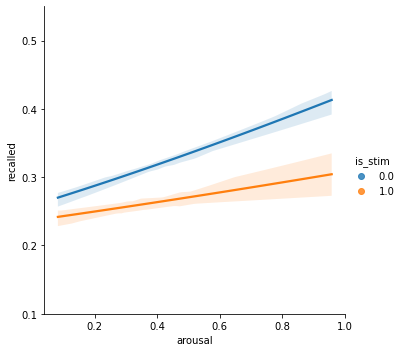

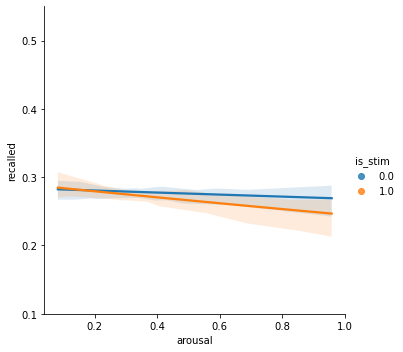

In [8]:
sns.lmplot(data=stim_behav_df[stim_behav_df.stim_reg=='Hipp'], x='arousal', y='recalled', hue='is_stim', logistic=True, n_boot=20, ci=68)
plt.ylim([0.1,0.55])
sns.lmplot(data=stim_behav_df[stim_behav_df.stim_reg=='MTL'], x='arousal', y='recalled', hue='is_stim', logistic=True, n_boot=20, ci=68)
plt.ylim([0.1,0.55])


(0.1, 0.55)

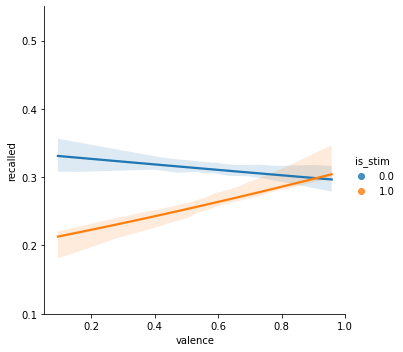

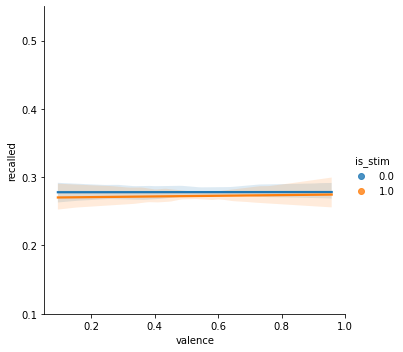

In [9]:
sns.lmplot(data=stim_behav_df[stim_behav_df.stim_reg=='Hipp'], x='valence', y='recalled', hue='is_stim', logistic=True, n_boot=20, ci=68)
plt.ylim([0.1,0.55])
sns.lmplot(data=stim_behav_df[stim_behav_df.stim_reg=='MTL'], x='valence', y='recalled', hue='is_stim', logistic=True, n_boot=20, ci=68)
plt.ylim([0.1,0.55])


<AxesSubplot:xlabel='is_stim', ylabel='recalled'>

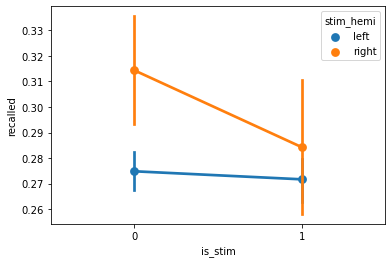

In [64]:
sns.pointplot(data=stim_behav_df[stim_behav_df.stim_reg=='MTL'], x='is_stim', y='recalled', hue='stim_hemi', ci=68)
# plt.ylim([0.2,0.45])
# sns.pointplot(data=stim_behav_df[stim_behav_df.stim_reg=='MTL'], x='is_stim', y='recalled', hue='stim_hemi', ci=68)
# plt.ylim([0.2,0.45])


In [3]:
# Model 1: Effect of stimulation to HippOnly on recall as a function of arousal and valence: 

stim_behav_df = pd.read_csv('/home1/salman.qasim/Salman_Project/FR_Emotion/all_stim_ev.csv')
# stim_behav_df = stim_behav_df.drop(columns=['Unnamed: 0'])

# Get only encoding events
stim_behav_df = stim_behav_df[stim_behav_df.type=='WORD']

# Get only hippocampal stim:
stim_behav_df = stim_behav_df[(stim_behav_df.stim_reg=='Hipp')]
 
# Center valence using mean of whole database to capture relative polarity
stim_behav_df['valence'] = stim_behav_df['valence'] - 0.5

# cat_type = CategoricalDtype(categories=['MTL', 'Amy', 'Hipp'], ordered=True)
# stim_behav_df.stim_reg = stim_behav_df.stim_reg.astype(cat_type)

cat_type = CategoricalDtype(categories=['right', 'left'], ordered=True)
stim_behav_df.stim_hemi = stim_behav_df.stim_hemi.astype(cat_type)

# cat_type = CategoricalDtype(categories=['pos', 'neutral', 'neg'], ordered=True)
# stim_behav_df.CV = stim_behav_df.CV.astype(cat_type)

# cat_type = CategoricalDtype(categories=['low', 'med', 'high'], ordered=True)
# stim_behav_df.CA = stim_behav_df.CA.astype(cat_type)

stim_behav_df = stim_behav_df[['recalled', 'valence', 'arousal', 'subject', 'is_stim', 'stim_hemi']]

y = 'recalled'
X = ['is_stim', 'arousal', 'valence', 'stim_hemi'] 
# Intx = None
Intx = ['is_stim:arousal', 'is_stim:valence']

rand_effect = ['subject']
categorical = ['is_stim', 'stim_hemi']
label = (f"{y}" + "_{}"*len(X)).format(*X) + '_HippOnly' 

# Drop nan data
stim_behav_df = stim_behav_df.dropna(subset=X)

run_model(stim_behav_df, y, X, Intx, rand_effect, chains=4, cores=4, tune=2000, draws=2000, target_accept=0.95,
          rand_slopes=False, categorical=categorical, label=label)

/tmp/2823834.1.jupyter.q/ipykernel_87061/2450537663.py:3: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  stim_behav_df = pd.read_csv('/home1/salman.qasim/Salman_Project/FR_Emotion/all_stim_ev.csv')
Modeling the probability that recalled==1
Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Convergence achieved at 18700
Interrupted at 18,699 [37%]: Average Loss = 5,458.1
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [1|subject_offset, 1|subject_sigma, is_stim:valence, is_stim:arousal, stim_hemi, valence, arousal, is_stim, Intercept]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 578 seconds.
The number of effective samples is smaller than 25% for some parameters.
/home1/salman.qasim/Salman_Python_Scripts/SQ_Projects/Bayesian_model_utils.py:142: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(results_df.reset_index().to_latex(index=False,


\begin{tabular}{|c|c|c|c|c|c|c|c|}
\toprule
               index &   mean &    sd &  hdi\_2.5\% &  hdi\_97.5\% \\ \hline
\midrule
        is\_stim[1.0] & -0.178 & 0.148 &    -0.459 &      0.123 \\ \hline
is\_stim:arousal[1.0] & -0.314 & 0.366 &    -0.991 &      0.433 \\ \hline
is\_stim:valence[1.0] &  0.697 & 0.353 &     0.003 &      1.375 \\ \hline
             arousal &  0.722 & 0.220 &     0.293 &      1.150 \\ \hline
is\_stim:arousal[1.0] & -0.314 & 0.366 &    -0.991 &      0.433 \\ \hline
             valence & -0.106 & 0.210 &    -0.495 &      0.315 \\ \hline
is\_stim:valence[1.0] &  0.697 & 0.353 &     0.003 &      1.375 \\ \hline
     stim\_hemi[left] & -0.520 & 0.299 &    -1.126 &      0.050 \\ \hline
\bottomrule
\end{tabular}



In [4]:
# Model 1: Effect of stimulation to HippOnly on recall as a function of arousal and valence: 

stim_behav_df = pd.read_csv('/home1/salman.qasim/Salman_Project/FR_Emotion/all_stim_ev.csv')
# stim_behav_df = stim_behav_df.drop(columns=['Unnamed: 0'])

# Get only encoding events
stim_behav_df = stim_behav_df[stim_behav_df.type=='WORD']

# Get only hippocampal stim:
stim_behav_df = stim_behav_df[(stim_behav_df.stim_reg=='MTL')]
 
# Center valence using mean of whole database to capture relative polarity
stim_behav_df['valence'] = stim_behav_df['valence'] - 0.5

# cat_type = CategoricalDtype(categories=['MTL', 'Amy', 'Hipp'], ordered=True)
# stim_behav_df.stim_reg = stim_behav_df.stim_reg.astype(cat_type)

cat_type = CategoricalDtype(categories=['right', 'left'], ordered=True)
stim_behav_df.stim_hemi = stim_behav_df.stim_hemi.astype(cat_type)

# cat_type = CategoricalDtype(categories=['pos', 'neutral', 'neg'], ordered=True)
# stim_behav_df.CV = stim_behav_df.CV.astype(cat_type)

# cat_type = CategoricalDtype(categories=['low', 'med', 'high'], ordered=True)
# stim_behav_df.CA = stim_behav_df.CA.astype(cat_type)

stim_behav_df = stim_behav_df[['recalled', 'valence', 'arousal', 'subject', 'is_stim', 'stim_hemi']]

y = 'recalled'
X = ['is_stim', 'arousal', 'valence', 'stim_hemi'] 
# Intx = None
Intx = ['is_stim:arousal', 'is_stim:valence']

rand_effect = ['subject']
categorical = ['is_stim', 'stim_hemi']
label = (f"{y}" + "_{}"*len(X)).format(*X) + '_MTLOnly' 

# Drop nan data
stim_behav_df = stim_behav_df.dropna(subset=X)

run_model(stim_behav_df, y, X, Intx, rand_effect, chains=4, cores=4, tune=2000, draws=2000, target_accept=0.95,
          rand_slopes=False, categorical=categorical, label=label)

/tmp/2823834.1.jupyter.q/ipykernel_87061/2525164685.py:3: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  stim_behav_df = pd.read_csv('/home1/salman.qasim/Salman_Project/FR_Emotion/all_stim_ev.csv')
Modeling the probability that recalled==1
Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Convergence achieved at 18400
Interrupted at 18,399 [36%]: Average Loss = 4,974
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [1|subject_offset, 1|subject_sigma, is_stim:valence, is_stim:arousal, stim_hemi, valence, arousal, is_stim, Intercept]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 937 seconds.
/home1/salman.qasim/Salman_Python_Scripts/SQ_Projects/Bayesian_model_utils.py:142: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(results_df.reset_index().to_latex(index=False,


\begin{tabular}{|c|c|c|c|c|c|c|c|}
\toprule
               index &   mean &    sd &  hdi\_2.5\% &  hdi\_97.5\% \\ \hline
\midrule
        is\_stim[1.0] & -0.021 & 0.154 &    -0.327 &      0.274 \\ \hline
is\_stim:arousal[1.0] &  0.011 & 0.388 &    -0.724 &      0.784 \\ \hline
is\_stim:valence[1.0] & -0.274 & 0.380 &    -1.020 &      0.462 \\ \hline
             arousal & -0.156 & 0.249 &    -0.642 &      0.335 \\ \hline
is\_stim:arousal[1.0] &  0.011 & 0.388 &    -0.724 &      0.784 \\ \hline
             valence &  0.084 & 0.241 &    -0.378 &      0.562 \\ \hline
is\_stim:valence[1.0] & -0.274 & 0.380 &    -1.020 &      0.462 \\ \hline
     stim\_hemi[left] & -0.385 & 0.642 &    -1.696 &      0.842 \\ \hline
\bottomrule
\end{tabular}



In [67]:
# Model 1: Effect of stimulation to HippOnly on recall as a function of arousal and valence: 

stim_behav_df = pd.read_csv('/home1/salman.qasim/Salman_Project/FR_Emotion/all_stim_ev.csv')
# stim_behav_df = stim_behav_df.drop(columns=['Unnamed: 0'])

# Get only encoding events
stim_behav_df = stim_behav_df[stim_behav_df.type=='WORD']

# Get only hippocampal stim:
stim_behav_df = stim_behav_df[(stim_behav_df.stim_reg=='Hipp')]
 
# Center valence using mean of whole database to capture relative polarity
stim_behav_df['valence'] = stim_behav_df['valence'] - 0.5

# cat_type = CategoricalDtype(categories=['MTL', 'Amy', 'Hipp'], ordered=True)
# stim_behav_df.stim_reg = stim_behav_df.stim_reg.astype(cat_type)

cat_type = CategoricalDtype(categories=['right', 'left'], ordered=True)
stim_behav_df.stim_hemi = stim_behav_df.stim_hemi.astype(cat_type)

stim_behav_df = stim_behav_df[['recalled', 'valence', 'arousal', 'subject', 'is_stim', 'stim_hemi']]

y = 'recalled'
X = ['is_stim', 'arousal', 'valence', 'stim_hemi'] 
# Intx = None
Intx = ['is_stim:valence', 'is_stim:stim_hemi']

rand_effect = ['subject']
categorical = ['is_stim', 'stim_hemi']
label = (f"{y}" + "_{}"*len(X)).format(*X) + 'stim_valence' + '_HippOnly' 

# Drop nan data
stim_behav_df = stim_behav_df.dropna(subset=X)

run_model(stim_behav_df, y, X, Intx, rand_effect, chains=4, cores=4, tune=1000, draws=1000, target_accept=0.95,
          rand_slopes=False, categorical=categorical, label=label)

/tmp/2823834.1.jupyter.q/ipykernel_20373/833036212.py:3: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  stim_behav_df = pd.read_csv('/home1/salman.qasim/Salman_Project/FR_Emotion/all_stim_ev.csv')
Modeling the probability that recalled==1
Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Convergence achieved at 17600
Interrupted at 17,599 [35%]: Average Loss = 5,610.2
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [1|subject_offset, 1|subject_sigma, is_stim:stim_hemi, is_stim:valence, stim_hemi, valence, arousal, is_stim, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 318 seconds.
The number of effective samples is smaller than 25% for some parameters.
/home1/salman.qasim/Salman_Python_Scripts/SQ_Projects/Bayesian_model_utils.py:142: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(results_df.reset_index().to_latex(index=False,


\begin{tabular}{|c|c|c|c|c|c|c|c|}
\toprule
                     index &   mean &    sd &  hdi\_2.5\% &  hdi\_97.5\% \\ \hline
\midrule
                is\_stim[1] & -0.091 & 0.089 &    -0.269 &      0.079 \\ \hline
        is\_stim:valence[1] &  0.584 & 0.347 &    -0.115 &      1.224 \\ \hline
is\_stim:stim\_hemi[1, left] & -0.327 & 0.110 &    -0.539 &     -0.108 \\ \hline
                   arousal &  0.618 & 0.170 &     0.278 &      0.940 \\ \hline
                   valence & -0.124 & 0.212 &    -0.529 &      0.285 \\ \hline
        is\_stim:valence[1] &  0.584 & 0.347 &    -0.115 &      1.224 \\ \hline
           stim\_hemi[left] & -0.409 & 0.298 &    -0.968 &      0.199 \\ \hline
is\_stim:stim\_hemi[1, left] & -0.327 & 0.110 &    -0.539 &     -0.108 \\ \hline
\bottomrule
\end{tabular}



In [46]:
# # Model 1: Effect of stimulation to HippOnly on recall as a function of arousal and valence: 

# stim_behav_df = pd.read_csv('/home1/salman.qasim/Salman_Project/FR_Emotion/all_stim_ev.csv')
# # stim_behav_df = stim_behav_df.drop(columns=['Unnamed: 0'])

# # Get only encoding events
# stim_behav_df = stim_behav_df[stim_behav_df.type=='WORD']

# # Get only hippocampal stim:
# stim_behav_df = stim_behav_df[(stim_behav_df.stim_reg=='Hipp')]
 
# # Center valence using mean of whole database to capture relative polarity
# stim_behav_df['valence'] = stim_behav_df['valence'] - 0.5


# stim_behav_df = stim_behav_df[['recalled', 'valence', 'arousal', 'subject', 'is_stim']]

# y = 'recalled'
# X = ['is_stim', 'valence'] 
# # Intx = None
# Intx = ['is_stim:valence']

# rand_effect = ['subject']
# categorical = ['is_stim']
# label = (f"{y}" + "_{}"*len(X)).format(*X) +'_HippOnly' 

# # Drop nan data
# stim_behav_df = stim_behav_df.dropna(subset=X)

# run_model(stim_behav_df, y, X, Intx, rand_effect, chains=4, cores=4, tune=1000, draws=1000, target_accept=0.95,
#           rand_slopes=False, categorical=categorical, label=label)

In [56]:
# Model 1: Effect of stimulation to HippOnly on recall as a function of arousal and valence: 

stim_behav_df = pd.read_csv('/home1/salman.qasim/Salman_Project/FR_Emotion/all_stim_ev.csv')
# stim_behav_df = stim_behav_df.drop(columns=['Unnamed: 0'])

# Get only encoding events
stim_behav_df = stim_behav_df[stim_behav_df.type=='WORD']

# Get only hippocampal stim:
stim_behav_df = stim_behav_df[(stim_behav_df.stim_reg=='MTL')]
 
# Center valence using mean of whole database to capture relative polarity
stim_behav_df['valence'] = stim_behav_df['valence'] - 0.5

# cat_type = CategoricalDtype(categories=['MTL', 'Amy', 'Hipp'], ordered=True)
# stim_behav_df.stim_reg = stim_behav_df.stim_reg.astype(cat_type)

cat_type = CategoricalDtype(categories=['right', 'left'], ordered=True)
stim_behav_df.stim_hemi = stim_behav_df.stim_hemi.astype(cat_type)

stim_behav_df = stim_behav_df[['recalled', 'valence', 'arousal', 'subject', 'is_stim', 'stim_hemi']]

y = 'recalled'
X = ['is_stim', 'arousal', 'valence', 'stim_hemi'] 
# Intx = None
Intx = ['is_stim:arousal', 'is_stim:valence', 'is_stim:stim_hemi']

rand_effect = ['subject']
categorical = ['is_stim', 'stim_hemi']
label = (f"{y}" + "_{}"*len(X)).format(*X) +'_MTLOnly' 

# Drop nan data
stim_behav_df = stim_behav_df.dropna(subset=X)

run_model(stim_behav_df, y, X, Intx, rand_effect, chains=4, cores=4, tune=1000, draws=1000, target_accept=0.95,
          rand_slopes=False, categorical=categorical, label=label)

/tmp/2823834.1.jupyter.q/ipykernel_20373/813365977.py:3: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  stim_behav_df = pd.read_csv('/home1/salman.qasim/Salman_Project/FR_Emotion/all_stim_ev.csv')
Modeling the probability that recalled==1
Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Convergence achieved at 18700
Interrupted at 18,699 [37%]: Average Loss = 5,003.6
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [1|subject_offset, 1|subject_sigma, is_stim:stim_hemi, is_stim:valence, is_stim:arousal, stim_hemi, valence, arousal, is_stim, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 522 seconds.
The number of effective samples is smaller than 25% for some parameters.
/home1/salman.qasim/Salman_Python_Scripts/SQ_Projects/Bayesian_model_utils.py:142: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(results_df.reset_index().to_latex(index=False,


\begin{tabular}{|c|c|c|c|c|c|c|c|c|c|}
\toprule
                     index &   mean &    sd &  hdi\_2.5\% &  hdi\_97.5\% \\ \hline
\midrule
                is\_stim[1] & -0.120 & 0.219 &    -0.542 &      0.334 \\ \hline
        is\_stim:arousal[1] &  0.015 & 0.388 &    -0.739 &      0.744 \\ \hline
        is\_stim:valence[1] & -0.259 & 0.385 &    -1.003 &      0.510 \\ \hline
is\_stim:stim\_hemi[1, left] &  0.113 & 0.177 &    -0.226 &      0.465 \\ \hline
                   arousal & -0.161 & 0.250 &    -0.659 &      0.322 \\ \hline
        is\_stim:arousal[1] &  0.015 & 0.388 &    -0.739 &      0.744 \\ \hline
                   valence &  0.076 & 0.239 &    -0.364 &      0.588 \\ \hline
        is\_stim:valence[1] & -0.259 & 0.385 &    -1.003 &      0.510 \\ \hline
           stim\_hemi[left] & -0.430 & 0.656 &    -1.742 &      0.862 \\ \hline
is\_stim:stim\_hemi[1, left] &  0.113 & 0.177 &    -0.226 &      0.465 \\ \hline
\bottomrule
\end{tabular}



In [44]:
# # Model 1: Effect of stimulation to HippOnly on recall as a function of arousal and valence: 

# stim_behav_df = pd.read_csv('/home1/salman.qasim/Salman_Project/FR_Emotion/all_stim_ev.csv')
# # stim_behav_df = stim_behav_df.drop(columns=['Unnamed: 0'])

# # Get only encoding events
# stim_behav_df = stim_behav_df[stim_behav_df.type=='WORD']

# # Get only hippocampal stim:
# stim_behav_df = stim_behav_df[(stim_behav_df.stim_reg=='MTL')]
 
# # Center valence using mean of whole database to capture relative polarity
# stim_behav_df['valence'] = stim_behav_df['valence'] - 0.5


# stim_behav_df = stim_behav_df[['recalled', 'valence', 'arousal', 'subject', 'is_stim']]

# y = 'recalled'
# X = ['is_stim', 'arousal'] 
# # Intx = None
# Intx = ['is_stim:arousal']

# rand_effect = ['subject']
# categorical = ['is_stim']
# label = (f"{y}" + "_{}"*len(X)).format(*X) +'_MTLOnly' 

# # Drop nan data
# stim_behav_df = stim_behav_df.dropna(subset=X)

# run_model(stim_behav_df, y, X, Intx, rand_effect, chains=4, cores=4, tune=1000, draws=1000, target_accept=0.95,
#           rand_slopes=False, categorical=categorical, label=label)

In [45]:
# # Model 1: Effect of stimulation to HippOnly on recall as a function of arousal and valence: 

# stim_behav_df = pd.read_csv('/home1/salman.qasim/Salman_Project/FR_Emotion/all_stim_ev.csv')
# # stim_behav_df = stim_behav_df.drop(columns=['Unnamed: 0'])

# # Get only encoding events
# stim_behav_df = stim_behav_df[stim_behav_df.type=='WORD']

# # Get only hippocampal stim:
# stim_behav_df = stim_behav_df[(stim_behav_df.stim_reg=='MTL')]
 
# # Center valence using mean of whole database to capture relative polarity
# stim_behav_df['valence'] = stim_behav_df['valence'] - 0.5


# stim_behav_df = stim_behav_df[['recalled', 'valence', 'arousal', 'subject', 'is_stim']]

# y = 'recalled'
# X = ['is_stim', 'valence'] 
# # Intx = None
# Intx = ['is_stim:valence']

# rand_effect = ['subject']
# categorical = ['is_stim']
# label = (f"{y}" + "_{}"*len(X)).format(*X) +'_MTLOnly' 

# # Drop nan data
# stim_behav_df = stim_behav_df.dropna(subset=X)

# run_model(stim_behav_df, y, X, Intx, rand_effect, chains=4, cores=4, tune=1000, draws=1000, target_accept=0.95,
#           rand_slopes=False, categorical=categorical, label=label)

In [69]:
# Model comparison: use PSI-LOO to determine which model to use. 

# Load each model
stim_valence = az.from_netcdf('/home1/salman.qasim/Salman_Project/FR_Emotion/BayesModels/recalled_is_stim_arousal_valence_stim_hemistim_arousal_HippOnly_model')
stim_arousal = az.from_netcdf(f'/home1/salman.qasim/Salman_Project/FR_Emotion/BayesModels/recalled_is_stim_arousal_valence_stim_hemistim_valence_HippOnly_model')

models = {"stim_valence": stim_valence, 
          "stim_arousal": stim_arousal}
df_compare = az.compare(models, ic='loo')
plot_df = df_compare.reset_index().rename(columns={'index':'model'})[['model', 'loo']]

c_string = '|c'*plot_df.shape[1] + '|'
print(plot_df.to_latex(index=False, 
                                        column_format=c_string).replace("\\\n", "\\ \hline\n"))  


\begin{tabular}{|c|c|}
\toprule
       model &          loo \\ \hline
\midrule
stim\_arousal & -4396.577528 \\ \hline
stim\_valence & -4397.671475 \\ \hline
\bottomrule
\end{tabular}



/tmp/2823834.1.jupyter.q/ipykernel_20373/3083055831.py:13: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(plot_df.to_latex(index=False,


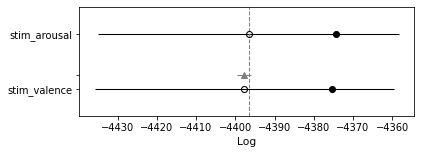

In [70]:
az.plot_compare(df_compare, insample_dev=True);

In [6]:
# Model 1: Effect of stimulation to HippOnly on recall as a function of arousal and valence: 

stim_behav_df = pd.read_csv('/home1/salman.qasim/Salman_Project/FR_Emotion/all_stim_ev.csv')
stim_behav_df = stim_behav_df[(stim_behav_df.serialpos>0) & (stim_behav_df.serialpos<13)] 

# Get only encoding events
stim_behav_df = stim_behav_df[stim_behav_df.type=='WORD']

# Get only hippocampal stim:
stim_behav_df = stim_behav_df[(stim_behav_df.stim_reg=='Hipp')]
 
# Center valence using mean of whole database to capture relative polarity
stim_behav_df['valence'] = stim_behav_df['valence'] - 0.5

# cat_type = CategoricalDtype(categories=['MTL', 'Amy', 'Hipp'], ordered=True)
# stim_behav_df.stim_reg = stim_behav_df.stim_reg.astype(cat_type)

cat_type = CategoricalDtype(categories=['right', 'left'], ordered=True)
stim_behav_df.stim_hemi = stim_behav_df.stim_hemi.astype(cat_type)

# cat_type = CategoricalDtype(categories=['pos', 'neutral', 'neg'], ordered=True)
# stim_behav_df.CV = stim_behav_df.CV.astype(cat_type)

# cat_type = CategoricalDtype(categories=['low', 'med', 'high'], ordered=True)
# stim_behav_df.CA = stim_behav_df.CA.astype(cat_type)

stim_behav_df = stim_behav_df[['recalled', 'valence', 'arousal', 'subject', 'is_stim', 'stim_hemi', 'serialpos']]

y = 'recalled'
X = ['is_stim', 'arousal', 'valence', 'serialpos', 'stim_hemi'] 
# Intx = None
Intx = ['is_stim:arousal', 'is_stim:valence', 'is_stim:serialpos']

rand_effect = ['subject']
categorical = ['is_stim', 'stim_hemi']
label = (f"{y}" + "_{}"*len(X)).format(*X) + '_HippOnly' 

# Drop nan data
stim_behav_df = stim_behav_df.dropna(subset=X)

run_model(stim_behav_df, y, X, Intx, rand_effect, chains=4, cores=4, tune=2000, draws=2000, target_accept=0.95,
          rand_slopes=False, categorical=categorical, label=label)

/tmp/2823834.1.jupyter.q/ipykernel_87061/3427922884.py:3: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  stim_behav_df = pd.read_csv('/home1/salman.qasim/Salman_Project/FR_Emotion/all_stim_ev.csv')
Modeling the probability that recalled==1
Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Convergence achieved at 23800
Interrupted at 23,799 [47%]: Average Loss = 6,034
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [1|subject_offset, 1|subject_sigma, is_stim:serialpos, is_stim:valence, is_stim:arousal, stim_hemi, serialpos, valence, arousal, is_stim, Intercept]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 686 seconds.
/home1/salman.qasim/Salman_Python_Scripts/SQ_Projects/Bayesian_model_utils.py:142: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(results_df.reset_index().to_latex(index=False,


\begin{tabular}{|c|c|c|c|c|c|c|c|c|c|c|}
\toprule
                 index &   mean &    sd &  hdi\_2.5\% &  hdi\_97.5\% \\ \hline
\midrule
          is\_stim[1.0] & -0.046 & 0.170 &    -0.366 &      0.299 \\ \hline
  is\_stim:arousal[1.0] & -0.300 & 0.360 &    -1.022 &      0.387 \\ \hline
  is\_stim:valence[1.0] &  0.668 & 0.365 &    -0.036 &      1.391 \\ \hline
is\_stim:serialpos[1.0] & -0.023 & 0.016 &    -0.053 &      0.010 \\ \hline
               arousal &  0.788 & 0.219 &     0.336 &      1.195 \\ \hline
  is\_stim:arousal[1.0] & -0.300 & 0.360 &    -1.022 &      0.387 \\ \hline
               valence & -0.097 & 0.216 &    -0.511 &      0.339 \\ \hline
  is\_stim:valence[1.0] &  0.668 & 0.365 &    -0.036 &      1.391 \\ \hline
             serialpos & -0.070 & 0.010 &    -0.089 &     -0.051 \\ \hline
is\_stim:serialpos[1.0] & -0.023 & 0.016 &    -0.053 &      0.010 \\ \hline
       stim\_hemi[left] & -0.531 & 0.297 &    -1.111 &      0.067 \\ \hline
\bottomrule
\end{tabular}



In [7]:
# Model 1: Effect of stimulation to HippOnly on recall as a function of arousal and valence: 

stim_behav_df = pd.read_csv('/home1/salman.qasim/Salman_Project/FR_Emotion/all_stim_ev.csv')
stim_behav_df = stim_behav_df[(stim_behav_df.serialpos>0) & (stim_behav_df.serialpos<13)] 

# Get only encoding events
stim_behav_df = stim_behav_df[stim_behav_df.type=='WORD']

# Get only hippocampal stim:
stim_behav_df = stim_behav_df[(stim_behav_df.stim_reg=='Hipp')]
 
# Center valence using mean of whole database to capture relative polarity
stim_behav_df['valence'] = stim_behav_df['valence'] - 0.5

# cat_type = CategoricalDtype(categories=['MTL', 'Amy', 'Hipp'], ordered=True)
# stim_behav_df.stim_reg = stim_behav_df.stim_reg.astype(cat_type)

cat_type = CategoricalDtype(categories=['right', 'left'], ordered=True)
stim_behav_df.stim_hemi = stim_behav_df.stim_hemi.astype(cat_type)

# cat_type = CategoricalDtype(categories=['pos', 'neutral', 'neg'], ordered=True)
# stim_behav_df.CV = stim_behav_df.CV.astype(cat_type)

# cat_type = CategoricalDtype(categories=['low', 'med', 'high'], ordered=True)
# stim_behav_df.CA = stim_behav_df.CA.astype(cat_type)

stim_behav_df = stim_behav_df[['recalled', 'valence', 'arousal', 'subject', 'is_stim', 'stim_hemi', 'serialpos']]

y = 'recalled'
X = ['is_stim', 'serialpos', 'stim_hemi'] 
# Intx = None
Intx = ['is_stim:serialpos']

rand_effect = ['subject']
categorical = ['is_stim', 'stim_hemi']
label = (f"{y}" + "_{}"*len(X)).format(*X) + '_HippOnly' 

# Drop nan data
stim_behav_df = stim_behav_df.dropna(subset=X)

run_model(stim_behav_df, y, X, Intx, rand_effect, chains=4, cores=4, tune=2000, draws=2000, target_accept=0.95,
          rand_slopes=False, categorical=categorical, label=label)

/tmp/2823834.1.jupyter.q/ipykernel_87061/3732889218.py:3: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  stim_behav_df = pd.read_csv('/home1/salman.qasim/Salman_Project/FR_Emotion/all_stim_ev.csv')
/home1/salman.qasim/miniconda3/envs/bambi_env/lib/python3.10/site-packages/bambi/models.py:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[obj_cols] = data[obj_cols].apply(lambda x: x.astype("category"))
Modeling the probability that recalled==1
Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Convergence achieved at 23400
Interrupted at 23,399 [46%]: Average Loss = 5,918.1
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [1|subject_offset, 1|subject_sigma, is_stim:serialpos, stim_hemi, serialpos, is_stim, Intercept]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 619 seconds.
The number of effective samples is smaller than 25% for some parameters.
/home1/salman.qasim/Salman_Python_Scripts/SQ_Projects/Bayesian_model_utils.py:142: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(results_df.reset_index().to_latex(index=False,


\begin{tabular}{|c|c|c|c|c|}
\toprule
                 index &   mean &    sd &  hdi\_2.5\% &  hdi\_97.5\% \\ \hline
\midrule
          is\_stim[1.0] & -0.099 & 0.110 &    -0.310 &      0.119 \\ \hline
is\_stim:serialpos[1.0] & -0.026 & 0.016 &    -0.058 &      0.003 \\ \hline
             serialpos & -0.067 & 0.009 &    -0.085 &     -0.048 \\ \hline
is\_stim:serialpos[1.0] & -0.026 & 0.016 &    -0.058 &      0.003 \\ \hline
       stim\_hemi[left] & -0.541 & 0.305 &    -1.136 &      0.062 \\ \hline
\bottomrule
\end{tabular}



In [6]:
# Model 1: Effect of stimulation to HippOnly on recall as a function of arousal and valence: 

stim_behav_df = pd.read_csv('/home1/salman.qasim/Salman_Project/FR_Emotion/all_stim_ev.csv')
stim_behav_df = stim_behav_df.drop(columns=['Unnamed: 0'])
# Get only encoding events
stim_behav_df = stim_behav_df[stim_behav_df.type=='WORD']

# Get only hippocampal stim:
stim_behav_df = stim_behav_df[stim_behav_df.stim_area=='Hipp']
 
# Set up squared valence 
stim_behav_df['valence'] = stim_behav_df['valence'] - 0.5


stim_behav_df = stim_behav_df[['recalled', 'valence', 'arousal', 'subj', 'is_stim']]

# # Get hemisphere
test = pd.read_csv('/home1/salman.qasim/Salman_Project/FR_Emotion/fr2catfr2_sub_stim_df.csv')
test['stim_hemi'] = test[['sub', 'stim_site']].apply(lambda x: x['stim_site'][2], axis=1)
subj_stim_hemi = test[['sub', 'stim_hemi']].rename(columns={'sub':'subj'})
subj_stim_hemi.stim_hemi = subj_stim_hemi.stim_hemi.apply(lambda x: 'left' if x!='R' else 'right')
stim_behav_df = stim_behav_df.merge(subj_stim_hemi.drop_duplicates(), on='subj')

# # GET RID OF WORD 1 in the non-stim pair: 
# stim_words = stim_behav_df[stim_behav_df.is_stim==1]
# nstim_words = stim_behav_df[stim_behav_df.is_stim==0].iloc[1::2]
# stim_behav_df = pd.concat([stim_words, nstim_words])
# cat_type = CategoricalDtype(categories=['right', 'left'], ordered=True)
# stim_behav_df.is_stim = stim_behav_df.is_stim.astype(cat_type)

cat_type = CategoricalDtype(categories=['right', 'left'], ordered=True)
stim_behav_df.stim_hemi = stim_behav_df.stim_hemi.astype(cat_type)

y = 'recalled'
X = ['is_stim', 'stim_hemi'] 
# Intx = None
Intx = ['is_stim:stim_hemi']

rand_effect = ['subj']
categorical=['is_stim', 'stim_hemi']
label = (f"{y}" + "_{}"*len(X)).format(*X) +'_HippOnly' 

# Drop nan data
stim_behav_df = stim_behav_df.dropna(subset=X)

run_model(stim_behav_df, y, X, Intx, rand_effect, chains=4, cores=4, tune=500, draws=1000,
          rand_slopes=False, categorical=categorical, label=label)

/tmp/2773771.1.jupyter.q/ipykernel_139008/2767588502.py:3: DtypeWarning: Columns (27) have mixed types. Specify dtype option on import or set low_memory=False.
  stim_behav_df = pd.read_csv('/home1/salman.qasim/Salman_Project/FR_Emotion/all_stim_ev.csv')
/home1/salman.qasim/miniconda3/envs/bambi_env/lib/python3.10/site-packages/bambi/models.py:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[obj_cols] = data[obj_cols].apply(lambda x: x.astype("category"))
Modeling the probability that recalled==1
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [1|subj_offset, 1|subj_sigma, is_stim:stim_hemi, stim_hemi, is_stim, Intercept]


Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 932 seconds.
The number of effective samples is smaller than 25% for some parameters.
/home1/salman.qasim/Salman_Python_Scripts/SQ_Projects/Bayesian_model_utils.py:136: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(results_df.reset_index().to_latex(index=False,


\begin{tabular}{|c|c|c|c|}
\toprule
                     index &   mean &    sd &  hdi\_2.5\% &  hdi\_97.5\% \\ \hline
\midrule
                is\_stim[1] & -0.182 & 0.107 &    -0.389 &      0.028 \\ \hline
is\_stim:stim\_hemi[1, left] &  0.049 & 0.126 &    -0.199 &      0.290 \\ \hline
           stim\_hemi[left] & -0.712 & 0.382 &    -1.482 &      0.010 \\ \hline
is\_stim:stim\_hemi[1, left] &  0.049 & 0.126 &    -0.199 &      0.290 \\ \hline
\bottomrule
\end{tabular}



In [18]:
stim_behav_df[['subj', 'stim_hemi']].groupby('subj').value_counts()

subj    stim_hemi
R1001P  left          600
        right           0
R1003P  left          300
        right           0
R1006P  left          600
        right           0
R1020J  right        1188
        left            0
R1022J  left          600
        right           0
R1027J  left          804
        right           0
R1033D  left          900
        right           0
R1056M  right         240
        left            0
R1067P  left          300
        right           0
R1077T  left          132
        right           0
R1085C  left          300
        right           0
R1092J  left          300
        right           0
R1101T  right         300
        left            0
R1150J  left          300
        right           0
R1157C  left          300
        right           0
R1192C  left          600
        right           0
dtype: int64

In [ ]:
# # Model 2: Effect of stimulation to Hipp on recall as a function of arousal and valence for only 1 word in pair: 

# stim_behav_df = pd.read_csv('/home1/salman.qasim/Salman_Project/FR_Emotion/all_stim_ev.csv')
# stim_behav_df = stim_behav_df.drop(columns=['Unnamed: 0'])
# # Get only encoding events
# stim_behav_df = stim_behav_df[stim_behav_df.type=='WORD']

# # Get only HIppAmy stim:
# stim_behav_df = stim_behav_df[stim_behav_df.stim_area=='Hipp']
 
# # Set up squared valence 
# stim_behav_df['valence'] = stim_behav_df['valence'] - stim_behav_df['valence'].mean()

# stim_behav_df = stim_behav_df[['recalled', 'valence', 'arousal', 'subj', 'is_stim']]

# # GET RID OF WORD 2 in the non-stim pair: 
# stim_words = stim_behav_df[stim_behav_df.is_stim==1]
# nstim_words = stim_behav_df[stim_behav_df.is_stim==0].iloc[::2]
# stim_behav_df = pd.concat([stim_words, nstim_words])

# y = 'recalled'
# X = ['arousal', 'valence', 'is_stim'] 
# # Intx = None
# Intx = ['arousal:valence',
#        'is_stim:valence', 
#        'is_stim:arousal']

# rand_effect = ['subj']
# categorical=['is_stim']
# label = (f"{y}" + "_{}"*len(X)).format(*X) +'_HippOnly' + '_Word1'

# # Drop nan data
# stim_behav_df = stim_behav_df.dropna(subset=X)

# run_model(stim_behav_df, y, X, Intx, rand_effect, chains=4, cores=4, tune=500, draws=1000,
#           rand_slopes=False, categorical=categorical, label=label)

In [7]:
# Model 1: Effect of stimulation to HippOnly on recall as a function of arousal and valence: 

stim_behav_df = pd.read_csv('/home1/salman.qasim/Salman_Project/FR_Emotion/all_stim_ev.csv')
stim_behav_df = stim_behav_df.drop(columns=['Unnamed: 0'])

# Get only encoding events
stim_behav_df = stim_behav_df[stim_behav_df.type=='WORD']

# Get only hippocampal stim:
stim_behav_df = stim_behav_df[(stim_behav_df.stim_area=='MTL')]
 
# Center valence using mean of whole database to capture relative polarity
stim_behav_df['valence'] = stim_behav_df['valence'] - 0.5


stim_behav_df = stim_behav_df[['recalled', 'valence', 'arousal', 'subj', 'is_stim']]

y = 'recalled'
X = ['is_stim', 'arousal'] 
# Intx = None
Intx = ['is_stim:arousal']

rand_effect = ['subj']
categorical = ['is_stim']
label = (f"{y}" + "_{}"*len(X)).format(*X) +'_MTLOnly' 

# Drop nan data
stim_behav_df = stim_behav_df.dropna(subset=X)

run_model(stim_behav_df, y, X, Intx, rand_effect, chains=4, cores=4, tune=1000, draws=1000, target_accept=0.85,
          rand_slopes=False, categorical=categorical, label=label)

/tmp/2773771.1.jupyter.q/ipykernel_123224/2905885996.py:3: DtypeWarning: Columns (27) have mixed types. Specify dtype option on import or set low_memory=False.
  stim_behav_df = pd.read_csv('/home1/salman.qasim/Salman_Project/FR_Emotion/all_stim_ev.csv')
/home1/salman.qasim/miniconda3/envs/bambi_env/lib/python3.10/site-packages/bambi/models.py:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[obj_cols] = data[obj_cols].apply(lambda x: x.astype("category"))
Modeling the probability that recalled==1
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [1|subj_offset, 1|subj_sigma, is_stim:arousal, arousal, is_stim, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1552 seconds.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 139 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7079956122866361, but should be close to 0.85. Try to increase the number of tuning steps.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/home1/salman.qasim/Salman_Python_Scripts/SQ_Projects/Bayesian_model_utils.py:136: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for forma

\begin{tabular}{|c|c|c|c|}
\toprule
             index &  mean &    sd &  hdi\_2.5\% &  hdi\_97.5\% \\ \hline
\midrule
        is\_stim[1] & 0.041 & 0.162 &    -0.235 &      0.389 \\ \hline
is\_stim:arousal[1] & 0.029 & 0.418 &    -0.851 &      0.773 \\ \hline
           arousal & 0.194 & 0.244 &    -0.269 &      0.655 \\ \hline
is\_stim:arousal[1] & 0.029 & 0.418 &    -0.851 &      0.773 \\ \hline
\bottomrule
\end{tabular}



In [3]:
# Model comparison: use PSI-LOO to determine which model to use. 

# Load each model
stim_arousal_Hipp = az.from_netcdf('/home1/salman.qasim/Salman_Project/FR_Emotion/BayesModels/final/behavioral/stim/recalled_is_stim_valence_HippOnly_model')
stim_arousal_MTL = az.from_netcdf(f'/home1/salman.qasim/Salman_Project/FR_Emotion/BayesModels/final/behavioral/stim/recalled_is_stim_arousal_MTLOnly_model')

models = {"stim_arousal_Hipp": stim_arousal_Hipp, 
          "stim_arousal_MTL": stim_arousal_MTL}

df_compare = az.compare(models, ic='loo')
plot_df = df_compare.reset_index().rename(columns={'index':'model'})[['model', 'loo']]

c_string = '|c'*plot_df.shape[1] + '|'
print(plot_df.to_latex(index=False, 
                                        column_format=c_string).replace("\\\n", "\\ \hline\n"))  
az.plot_compare(df_compare, insample_dev=True)

ValueError: The number of observations should be the same across all models

In [ ]:
# # Model 1: Effect of stimulation to HippOnly on recall as a function of arousal and valence: 

# stim_behav_df = pd.read_csv('/home1/salman.qasim/Salman_Project/FR_Emotion/all_stim_ev.csv')
# stim_behav_df = stim_behav_df.drop(columns=['Unnamed: 0'])

# # Get only encoding events
# stim_behav_df = stim_behav_df[stim_behav_df.type=='WORD']

# # Get only hippocampal stim:
# stim_behav_df = stim_behav_df[(stim_behav_df.stim_area=='MTL')]
 
# # Center valence using mean of whole database to capture relative polarity
# stim_behav_df['valence'] = stim_behav_df['valence'] - 0.5


# stim_behav_df = stim_behav_df[['recalled', 'valence', 'arousal', 'subj', 'is_stim']]

# y = 'recalled'
# X = ['is_stim', 'valence'] 
# # Intx = None
# Intx = ['is_stim:valence']

# rand_effect = ['subj']
# categorical = ['is_stim']
# label = (f"{y}" + "_{}"*len(X)).format(*X) +'_MTLOnly' 

# # Drop nan data
# stim_behav_df = stim_behav_df.dropna(subset=X)

# run_model(stim_behav_df, y, X, Intx, rand_effect, chains=4, cores=4, tune=1000, draws=1000, target_accept=0.85,
#           rand_slopes=False, categorical=categorical, label=label)

In [ ]:
# # Control: Effect of stimulation to HippAmy on recall as a function of arousal and valence: 

# stim_behav_df = pd.read_csv('/home1/salman.qasim/Salman_Project/FR_Emotion/all_stim_ev.csv')
# stim_behav_df = stim_behav_df.drop(columns=['Unnamed: 0'])
# # Get only encoding events
# stim_behav_df = stim_behav_df[stim_behav_df.type=='WORD']

# # Get only HIppAmy stim:
# stim_behav_df = stim_behav_df[stim_behav_df.stim_group=='HippAmy']
 
# # Center valence using mean of whole database to capture relative polarity
# stim_behav_df['valence'] = stim_behav_df['valence'] - 0.5


# stim_behav_df = stim_behav_df[['recalled', 'valence', 'arousal', 'subj', 'is_stim']]

# y = 'recalled'
# X = ['arousal', 'valence', 'is_stim'] 
# # Intx = None
# Intx = ['is_stim:valence', 
#        'is_stim:arousal']

# rand_effect = ['subj']
# categorical = ['is_stim']
# label = (f"{y}" + "_{}"*len(X)).format(*X) +'_HippAmy' 

# # Drop nan data
# stim_behav_df = stim_behav_df.dropna(subset=X)

# run_model(stim_behav_df, y, X, Intx, rand_effect, chains=4, cores=4, tune=500, draws=1000,
#           rand_slopes=False, categorical=categorical, label=label)

One important problem: arousal:valence is clearly important, but assessing this effect in a 3-way interaction is not possible in this smaller cohort of subjects. However, I really am interested in seeing what word features interacts most with depressive state in predicting memory; for that, I can complete a model comparison between an arousal-BDI model and a valence-BDI model. 

In [2]:
# First, load the Beck Scores: 
BeckScores = pd.read_csv('/home1/salman.qasim/Salman_Project/FR_Emotion/Beck_Scores.csv')
BeckScores.rename(columns={'Subject Code':'subject'}, inplace=True)

behav_df = pd.read_csv('/home1/salman.qasim/Salman_Project/FR_Emotion/events_all_patients_revision.csv', memory_map=True)

behav_df = behav_df.drop(columns=['Unnamed: 0'])
# Get only encoding events
behav_df = behav_df[behav_df.type=='WORD']

# add back in the Beck Scores 
behav_df = behav_df.merge(BeckScores, on='subject')

# make squared valence
behav_df['valence'] = behav_df['valence'] - 0.5

/tmp/2844356.1.jupyter.q/ipykernel_591/2442864769.py:5: DtypeWarning: Columns (3,6,94) have mixed types. Specify dtype option on import or set low_memory=False.
  behav_df = pd.read_csv('/home1/salman.qasim/Salman_Project/FR_Emotion/events_all_patients_revision.csv', memory_map=True)


In [6]:
subj_level_df = behav_df.groupby(['subject']).mean().reset_index()[['subject', 'recalled', 'BDI']]

<AxesSubplot:xlabel='BDI', ylabel='recalled'>

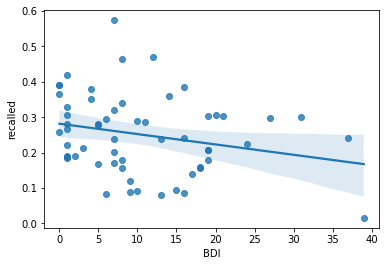

In [7]:
sns.regplot(data=subj_level_df, x='BDI', y='recalled')

In [9]:
from scipy.stats import pearsonr
pearsonr(subj_level_df.BDI,
         subj_level_df.recalled)

(-0.24401027522735352, 0.06490907741427034)

In [11]:
# Model XX: does depression interact with word arousal to influence memory?

# First, load the Beck Scores: 
BeckScores = pd.read_csv('/home1/salman.qasim/Salman_Project/FR_Emotion/Beck_Scores.csv')
BeckScores.rename(columns={'Subject Code':'subject'}, inplace=True)

behav_df = pd.read_csv('/home1/salman.qasim/Salman_Project/FR_Emotion/events_all_patients_revision.csv', memory_map=True)

behav_df = behav_df.drop(columns=['Unnamed: 0'])
# Get only encoding events
behav_df = behav_df[behav_df.type=='WORD']

# add back in the Beck Scores 
behav_df = behav_df.merge(BeckScores, on='subject')

# make squared valence
behav_df['valence'] = behav_df['valence'] - 0.5

behav_df = behav_df[['recalled', 'BDI', 'BAI', 'subject']]

y = 'recalled'
X = ['BDI', 'BAI']
Intx= ['BDI:BAI']

rand_effect = ['subject']

# Drop nan data
behav_df = behav_df.dropna(subset=X)

label = (f"{y}" + "_{}"*len(X)).format(*X) + '_allFRpts'

# Run the model 
run_model(behav_df, y, X, Intx, rand_effect, chains=4, cores=4, tune=1000, draws=1000, 
          label = label, rand_slopes=False)

/tmp/2844356.1.jupyter.q/ipykernel_591/289850709.py:7: DtypeWarning: Columns (3,6,94) have mixed types. Specify dtype option on import or set low_memory=False.
  behav_df = pd.read_csv('/home1/salman.qasim/Salman_Project/FR_Emotion/events_all_patients_revision.csv', memory_map=True)
Modeling the probability that recalled==1
Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Convergence achieved at 47500
Interrupted at 47,499 [94%]: Average Loss = 1.3584e+05
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [1|subject_offset, 1|subject_sigma, BDI:BAI, BAI, BDI, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2719 seconds.
The number of effective samples is smaller than 25% for some parameters.
/home1/salman.qasim/Salman_Python_Scripts/SQ_Projects/Bayesian_model_utils.py:142: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(results_df.reset_index().to_latex(index=False,


\begin{tabular}{|c|c|c|c|}
\toprule
  index &   mean &    sd &  hdi\_2.5\% &  hdi\_97.5\% \\ \hline
\midrule
    BDI & -0.049 & 0.016 &    -0.080 &     -0.015 \\ \hline
BDI:BAI &  0.001 & 0.001 &    -0.001 &      0.003 \\ \hline
    BAI &  0.005 & 0.018 &    -0.026 &      0.043 \\ \hline
BDI:BAI &  0.001 & 0.001 &    -0.001 &      0.003 \\ \hline
\bottomrule
\end{tabular}



In [2]:
# Model XX: does depression interact with word arousal to influence memory?

# First, load the Beck Scores: 
BeckScores = pd.read_csv('/home1/salman.qasim/Salman_Project/FR_Emotion/Beck_Scores.csv')
BeckScores.rename(columns={'Subject Code':'subject'}, inplace=True)

behav_df = pd.read_csv('/home1/salman.qasim/Salman_Project/FR_Emotion/events_all_patients_revision.csv', memory_map=True)

behav_df = behav_df.drop(columns=['Unnamed: 0'])
# Get only encoding events
behav_df = behav_df[behav_df.type=='WORD']

# add back in the Beck Scores 
behav_df = behav_df.merge(BeckScores, on='subject')

# make squared valence
behav_df['valence'] = behav_df['valence'] - 0.5

behav_df = behav_df[['recalled', 'subject', 'BDI', 'arousal']]

y = 'recalled'
X = ['BDI', 'arousal']
Intx= ['BDI:arousal']

rand_effect = ['subject']

# Drop nan data
behav_df = behav_df.dropna(subset=X)

label = (f"{y}" + "_{}"*len(X)).format(*X) + '_allFRpts'

# Run the model 
run_model(behav_df, y, X, Intx, rand_effect, chains=4, cores=4, tune=1000, draws=1000, 
          label = label, rand_slopes=False)

/tmp/2818473.1.jupyter.q/ipykernel_85372/3484453561.py:7: DtypeWarning: Columns (3,6,94) have mixed types. Specify dtype option on import or set low_memory=False.
  behav_df = pd.read_csv('/home1/salman.qasim/Salman_Project/FR_Emotion/events_all_patients_revision.csv', memory_map=True)
WARNING (theano.link.c.cmodule): ModuleCache.refresh() Found key without dll in cache, deleting it. /home1/salman.qasim/.theano/compiledir_Linux-3.10-el7.x86_64-x86_64-with-glibc2.17-x86_64-3.10.4-64/tmp1cu7lf7c/key.pkl
Modeling the probability that recalled==1
Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Convergence achieved at 33700
Interrupted at 33,699 [67%]: Average Loss = 37,176
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [1|subject_offset, 1|subject_sigma, BDI:arousal, arousal, BDI, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1227 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.
/home1/salman.qasim/Salman_Python_Scripts/SQ_Projects/Bayesian_model_utils.py:142: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(results_df.reset_index().to_latex(index=False,


\begin{tabular}{|c|c|c|c|}
\toprule
      index &   mean &    sd &  hdi\_2.5\% &  hdi\_97.5\% \\ \hline
\midrule
        BDI & -0.018 & 0.011 &    -0.038 &      0.003 \\ \hline
BDI:arousal & -0.013 & 0.008 &    -0.028 &      0.002 \\ \hline
    arousal &  0.458 & 0.104 &     0.262 &      0.666 \\ \hline
BDI:arousal & -0.013 & 0.008 &    -0.028 &      0.002 \\ \hline
\bottomrule
\end{tabular}



In [12]:
# Model XX: does depression interact with word valence to influence memory?

# First, load the Beck Scores: 
BeckScores = pd.read_csv('/home1/salman.qasim/Salman_Project/FR_Emotion/Beck_Scores.csv')
BeckScores.rename(columns={'Subject Code':'subject'}, inplace=True)

behav_df = pd.read_csv('/home1/salman.qasim/Salman_Project/FR_Emotion/events_all_patients_revision.csv', memory_map=True)

behav_df = behav_df.drop(columns=['Unnamed: 0'])
# Get only encoding events
behav_df = behav_df[behav_df.type=='WORD']

# add back in the Beck Scores 
behav_df = behav_df.merge(BeckScores, on='subject')

# make squared valence
behav_df['valence'] = (behav_df.valence - 0.5)

behav_df = behav_df[['recalled', 'subject', 'BDI', 'valence']]

y = 'recalled'
X = ['BDI', 'valence']
Intx= ['BDI:valence']

rand_effect = ['subject']

# Drop nan data
behav_df = behav_df.dropna(subset=X)

label = (f"{y}" + "_{}"*len(X)).format(*X) + '_allFRpts'

# Run the model 
run_model(behav_df, y, X, Intx, rand_effect, chains=4, cores=4, tune=1000, draws=1000, 
          label = label, rand_slopes=False)

/tmp/2844356.1.jupyter.q/ipykernel_591/2037038955.py:7: DtypeWarning: Columns (3,6,94) have mixed types. Specify dtype option on import or set low_memory=False.
  behav_df = pd.read_csv('/home1/salman.qasim/Salman_Project/FR_Emotion/events_all_patients_revision.csv', memory_map=True)
Modeling the probability that recalled==1
Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Convergence achieved at 30200
Interrupted at 30,199 [60%]: Average Loss = 35,568
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [1|subject_offset, 1|subject_sigma, BDI:valence, valence, BDI, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1204 seconds.
The number of effective samples is smaller than 10% for some parameters.
/home1/salman.qasim/Salman_Python_Scripts/SQ_Projects/Bayesian_model_utils.py:142: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(results_df.reset_index().to_latex(index=False,


\begin{tabular}{|c|c|c|c|}
\toprule
      index &   mean &    sd &  hdi\_2.5\% &  hdi\_97.5\% \\ \hline
\midrule
        BDI & -0.023 & 0.010 &    -0.043 &     -0.004 \\ \hline
BDI:valence & -0.001 & 0.008 &    -0.016 &      0.014 \\ \hline
    valence & -0.152 & 0.104 &    -0.348 &      0.052 \\ \hline
BDI:valence & -0.001 & 0.008 &    -0.016 &      0.014 \\ \hline
\bottomrule
\end{tabular}



Is BDI more predictive of memory when taking word arousal or word valence into account? My hypothesis is valence - as depression maybe makes people more sensitive to that. 

/tmp/2818473.1.jupyter.q/ipykernel_85372/1926120203.py:15: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(plot_df.to_latex(index=False,


\begin{tabular}{|c|c|}
\toprule
      model &           loo \\ \hline
\midrule
BDI\_arousal & -25296.711792 \\ \hline
BDI\_valence & -25308.391114 \\ \hline
\bottomrule
\end{tabular}



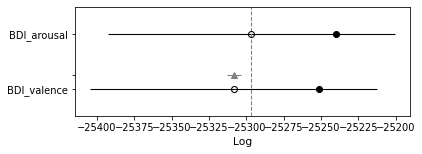

In [4]:
# Model comparison: use PSI-LOO

# Load each model
save_dir = '/home1/salman.qasim/Salman_Project/FR_Emotion/BayesModels'
BDI_arousal = az.from_netcdf(f'{save_dir}/recalled_BDI_arousal_allFRpts_model')
BDI_valence = az.from_netcdf(f'{save_dir}/recalled_BDI_valence_squared_allFRpts_model')

models = {"BDI_arousal": BDI_arousal, 
          "BDI_valence": BDI_valence}

df_compare = az.compare(models, ic='loo')
plot_df = df_compare.reset_index().rename(columns={'index':'model'})[['model', 'loo']]

c_string = '|c'*plot_df.shape[1] + '|'
print(plot_df.to_latex(index=False, 
                                        column_format=c_string).replace("\\\n", "\\ \hline\n"))  
az.plot_compare(df_compare, insample_dev=True)
plt.savefig(f'{save_dir}/BDI_arousal_valence_comparison.pdf')

In [12]:
# Model 3 control: Effect of depression on recall as a function of cont. valence and cont. arousal: 

# First, load the Beck Scores: 
BeckScores = pd.read_csv('/home1/salman.qasim/Salman_Project/FR_Emotion/Beck_Scores.csv')
BeckScores.rename(columns={'Subject Code':'subject'}, inplace=True)

# behav_df = pd.read_csv('/home1/salman.qasim/Salman_Project/FR_Emotion/events_all.csv')
# behav_df = behav_df.drop(columns=['Unnamed: 0'])
# # Get only encoding events
# behav_df = behav_df[behav_df.type=='WORD']

behav_df = pd.read_csv('/home1/salman.qasim/Salman_Project/FR_Emotion/events_all_patients.csv', memory_map=True)

behav_df = behav_df.drop(columns=['Unnamed: 0'])
# Get only encoding events
behav_df = behav_df[behav_df.type=='WORD']

# add back in the Beck Scores 
behav_df = behav_df.merge(BeckScores, on='subject')

# Using terciles:
behav_df['CBDI'] = pd.qcut(behav_df['BDI'], q=3,
                                                    labels=['low', 'med', 'high'])
behav_df['CBAI'] = pd.qcut(behav_df['BAI'], q=3,
                                                    labels=['low', 'med', 'high'])

# # Should I get rid of the neutral CBDI? Not in the original analysis.... 
behav_df = behav_df[behav_df['CBDI']!='med']

# make squared valence
behav_df['valence'] = behav_df['valence'] - behav_df['valence'].mean()

# behav_df['valence_squared'] = behav_df['valence']**2

cat_type = CategoricalDtype(categories=['low', 'high'], ordered=True)
behav_df.CBDI = behav_df.CBDI.astype(cat_type)


behav_df = behav_df[['recalled', 'arousal', 'valence', 'subject', 'CBDI']]

y = 'recalled'
X = ['arousal', 'valence', 'CBDI'] 
Intx = ['arousal:valence',
        'CBDI:valence',
        'CBDI:arousal',
        'CBDI:arousal:valence']
rand_effect = ['subject']
categorical = ['CBDI']      

# Drop nan data
behav_df = behav_df.dropna(subset=X)

label = (f"{y}" + "_{}"*len(X)).format(*X) + '_allFRpts'

# Run the model 
run_model(behav_df, y, X, Intx, rand_effect, chains=4, cores=4, tune=1000, draws=1000, target_accept=0.8, 
          label = label, rand_slopes=False)

/tmp/2773771.1.jupyter.q/ipykernel_75802/2290703427.py:12: DtypeWarning: Columns (4,26,31) have mixed types. Specify dtype option on import or set low_memory=False.
  behav_df = pd.read_csv('/home1/salman.qasim/Salman_Project/FR_Emotion/events_all_patients.csv', memory_map=True)
Modeling the probability that recalled==1
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...

KeyboardInterrupt



In [ ]:
# Model 3 control: Effect of depression on recall as a function of cont. valence and cont. arousal: 

# First, load the Beck Scores: 
BeckScores = pd.read_csv('/home1/salman.qasim/Salman_Project/FR_Emotion/Beck_Scores.csv')
BeckScores.rename(columns={'Subject Code':'subject'}, inplace=True)

behav_df = pd.read_csv('/home1/salman.qasim/Salman_Project/FR_Emotion/events_all.csv')
behav_df = behav_df.drop(columns=['Unnamed: 0'])
# Get only encoding events
behav_df = behav_df[behav_df.type=='WORD']

# add back in the Beck Scores 
behav_df = behav_df.merge(BeckScores, on='subject')

# Using terciles:
behav_df['CBDI'] = pd.qcut(behav_df['BDI'], q=3,
                                                    labels=['low', 'med', 'high'])
behav_df['CBAI'] = pd.qcut(behav_df['BAI'], q=3,
                                                    labels=['low', 'med', 'high'])

# # Should I get rid of the neutral CBDI? Not in the original analysis.... 
# behav_df = behav_df[behav_df['CBDI']!='med']

# make squared valence
behav_df['valence'] = behav_df['valence'] - behav_df['valence'].mean()

# behav_df['valence_squared'] = behav_df['valence']**2

cat_type = CategoricalDtype(categories=['low', 'high'], ordered=True)
behav_df.CBDI = behav_df.CBDI.astype(cat_type)


behav_df = behav_df[['recalled', 'valence', 'subject', 'BDI']]

y = 'recalled'
X = ['valence', 'BDI'] 
Intx = ['BDI:valence']
rand_effect = ['subject']
# categorical = ['CBDI']      

# Drop nan data
behav_df = behav_df.dropna(subset=X)

run_model(behav_df, y, X, Intx, rand_effect, rand_slopes=False, 
          chains=4, cores=4, tune=1000, draws=1000, target_accept=0.95, categorical=None)

In [6]:
# Model comparison: use PSI-LOO to determine which model to use for the depression data

# Load each model
depression_arousal = az.from_netcdf('/home1/salman.qasim/Salman_Project/FR_Emotion/BayesModels/recalled_arousal_valence_CBDI_model')
depression_valence = az.from_netcdf(f'/home1/salman.qasim/Salman_Project/FR_Emotion/BayesModels/recalled_arousal_CV_CBDI_model')

models = {"depression_arousal": depression_arousal, 
          "depression_valence": depression_valence}
df_compare = az.compare(models, ic='loo')
plot_df = df_compare.reset_index().rename(columns={'index':'model'})[['model', 'loo']]

c_string = '|c'*plot_df.shape[1] + '|'
print(plot_df.to_latex(index=False, 
                                        column_format=c_string).replace("\\\n", "\\ \hline\n"))  


\begin{tabular}{|c|c|}
\toprule
              model &           loo \\ \hline
\midrule
             binned & -18200.103060 \\ \hline
continuous (linear) & -18200.789948 \\ \hline
\bottomrule
\end{tabular}



/tmp/2765880.1.jupyter.q/ipykernel_140521/3340815604.py:13: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(plot_df.to_latex(index=False,


In [55]:
# This is word-level data. How do I recover electrode identity? 
pow_df = pd.read_csv('/home1/salman.qasim/Salman_Project/FR_Emotion/LM_data_128_30_noIED_elecInfo.csv')
pow_df = pow_df.drop(columns=['Unnamed: 0'])


In [57]:
pow_df = pow_df[pow_df.region!='Frontal']

In [28]:
# # Load all the stim models to see what best explains recall performance: 
# X = ['stim', 'stim_hemi'] 
# Intx = ['stim',
#         'stim:stim_hemi']
# # Load each model
# models = {}
# for sr in ['Hipp']:
#     for rr in ['Hipp']:
#         for y in ['theta_diff', 'alpha_diff', 'beta_diff', 'hfa_diff']:
#             label = (f"{y}" + "_{}"*len(X)).format(*X)+f'stim_{sr}_rec{rr}_model'
#             models[f'{y}_stim_{sr}_rec{rr}'] =  az.from_netcdf(f'/home1/salman.qasim/Salman_Project/FR_Emotion/BayesModels/{label}')
        
# df_compare = az.compare(models, ic='loo')
# plot_df = df_compare.reset_index().rename(columns={'index':'model'})[['model', 'loo']]

# c_string = '|c'*plot_df.shape[1] + '|'
# print(plot_df.to_latex(index=False, 
#                                         column_format=c_string).replace("\\\n", "\\ \hline\n"))  


In [ ]:
# Code for plotting posterior predictive 

# model.predict(results, kind="pps")
# az.plot_ppc(results)

In [ ]:
# Code for saving and loading models

# az.to_netcdf(results, '/home1/salman.qasim/Salman_Project/FR_Emotion/BayesModels/test_save')
# az.from_netcdf('/home1/salman.qasim/Salman_Project/FR_Emotion/BayesModels/test_save')